# RL

In [1]:
## first, import the libraries we are going to use

import matplotlib.pyplot as plt
import sys
import numpy as np 
import math
import decimal
from collections import namedtuple
import pypfopt as pyp

import time
import random
import pandas as pd
import seaborn as sns
import json

In [2]:
minute_df_usd_price_est = pd.read_csv('minute_data_mid_usd_est.csv', index_col=0)
minute_df_usd_price_est = minute_df_usd_price_est[['USD.EUR.SPOT','USD.CAD.SPOT','USD.JPY.SPOT']]
minute_df_usd_price_est = minute_df_usd_price_est.ffill()
minute_df_usd_price_est.index = pd.to_datetime(minute_df_usd_price_est.index)

In [3]:
ret_df = minute_df_usd_price_est.pct_change()
ret_df_bps = ret_df*10000

In [4]:
hour_start = minute_df_usd_price_est.iloc[::60, :]

In [5]:
hour_start_train = hour_start[hour_start.index < pd.Timestamp(2022,5,1)]
hour_start_backtest = hour_start[(hour_start.index >= pd.Timestamp(2022,5,1)) & (hour_start.index < pd.Timestamp(2022,6,1))]
hour_start_test = hour_start[(hour_start.index >= pd.Timestamp(2022,6,1))]

In [6]:
hour_start_train

,USD.EUR.SPOT,USD.CAD.SPOT,USD.JPY.SPOT
time_est,,,
2022-01-02 18:00:00,1.137645,0.791258,0.008687
2022-01-02 19:00:00,1.137330,0.789999,0.008685
2022-01-02 20:00:00,1.136160,0.790267,0.008675
2022-01-02 21:00:00,1.135710,0.789777,0.008678
2022-01-02 22:00:00,1.134250,0.789092,0.008675
...,...,...,...
2022-04-29 12:00:00,1.053635,0.780930,0.007702
2022-04-29 13:00:00,1.055030,0.780323,0.007711
2022-04-29 14:00:00,1.057235,0.780582,0.007723


In [7]:
def runif(): 
    """uniform random number generator"""
    return np.random.uniform(0, 1, 1)[0]

In [8]:
def index_list(L): 
    """from a list, build a dictionary which list element to position"""
    return dict(zip(L, [x for x in range(0, len(L))]))

In [9]:
Action = namedtuple('Action', ['weight'])
State = namedtuple('State', ['hour'])

In [63]:
weightOptions = [(1/3,1/3,1/3),(1/2,1/4,1/4),(1/4,1/2,1/4),(1/4,1/4,1/2)]
# weightOptions = [(1/3,1/3,1/3),(1/10,1/10,8/10),(1/10,8/10,1/10),(8/10,1/10,1/10)]
# weightOptions = [(1,0,0),(0,1,0),(0,0,1)]
# weightOptions = [(1/3,1/3,1/3),(1,0,0),(0,1,0),(0,0,1)]

actionSpace = [Action(w) for w in weightOptions]

hours = np.arange(24)
hours = np.delete(hours,17)
stateSpace = [State(h) for h in hours]

In [64]:
alpha = 0.01 ## learning rate

class TabularQLearner:
    def __init__(self, act_space, state_space, eps=0.1):
        self.actions = act_space
        self.states = state_space
        self.lookup = index_list(state_space)
        self.Q = np.zeros((len(self.states), len(self.actions)))
        self.epsilon = eps
        self.action_lookup = index_list(act_space)
        self.zero_trade = self.action_lookup[act_space[0]]

    def __greedy_action_index(self, state_index):
        """calculate the integer for indexing into self.Q or self.actions of the greedy action"""
        q = self.Q[state_index]
        if not np.any(q):
            return self.zero_trade
        else:
            return np.argmax(q)

    def greedy_action(self, state):
        """calculate the actual greedy action, not just its index"""
        return self.actions[self.__greedy_action_index(self.lookup[state])]

    def maxQ(self, state):
        return max(self.Q[self.lookup[state]])

    def train(self, hour_start):
        for h in range(len(hour_start)-1):
            curr = State(hour_start.index[h].hour)
            i = self.lookup[curr]

            rand = runif()
            # with probability epsilon, select action randomly from amongst all available actions with equal probability
            if rand <= self.epsilon:
                a = random.choice(self.actions)
            else:
                a = self.greedy_action(curr)
            j = self.action_lookup[a]
            
            # for reward calculation
            train_df = ret_df[(ret_df.index <= hour_start.index[h+1]) & (ret_df.index > hour_start.index[h])]
            
            train_performance = list(a.weight)*train_df
            train_port = train_performance.sum(axis=1)
            reward = -train_port.var()
            
            self.Q[i,j] = self.Q[i,j] + alpha * (reward - self.Q[i,j])

In [65]:
learner = TabularQLearner(actionSpace, stateSpace, eps=0.1)
learner.train(hour_start_train)

In [34]:
learner.Q

array([[-6.23067872e-09, -5.27096389e-09, -1.40486892e-08],
       [-8.53691628e-09, -7.97253026e-09, -7.47464493e-09],
       [-1.51683253e-08, -1.41270535e-08, -2.05993244e-08],
       [-2.13557094e-08, -1.88574068e-08, -1.97886852e-08],
       [-1.71278865e-08, -1.42815748e-08, -1.54717878e-08],
       [-1.32372524e-08, -1.14130005e-08, -1.30388439e-08],
       [-1.26870956e-08, -1.16185651e-08, -1.82849594e-08],
       [-2.00786731e-08, -1.89237528e-08, -2.01245149e-08],
       [-3.70265828e-08, -3.24337173e-08, -3.56410669e-08],
       [-3.73821453e-08, -3.24796497e-08, -3.21192145e-08],
       [-4.19877833e-08, -3.85412475e-08, -4.25710569e-08],
       [-2.17712860e-08, -2.20349860e-08, -3.61262140e-08],
       [-1.56960574e-08, -1.61894848e-08, -1.58741539e-08],
       [-1.61204869e-08, -1.21383208e-08, -1.28749587e-08],
       [-2.13783904e-08, -1.83399182e-08, -1.99781555e-08],
       [-8.65038230e-09, -8.44281110e-09, -9.27383401e-09],
       [-1.29153518e-08, -2.30204666e-08

In [66]:
qfunction = pd.DataFrame(columns=['hour', 'optimal_weight_eur', 'optimal_weight_cad', 'optimal_weight_jpy'])
for s in stateSpace:
    optimal_weight = learner.greedy_action(s).weight
    qfunction = qfunction.append({'hour': s.hour, 'optimal_weight_eur': optimal_weight[0], 'optimal_weight_cad': optimal_weight[1], 'optimal_weight_jpy': optimal_weight[2]}, ignore_index = True)
    

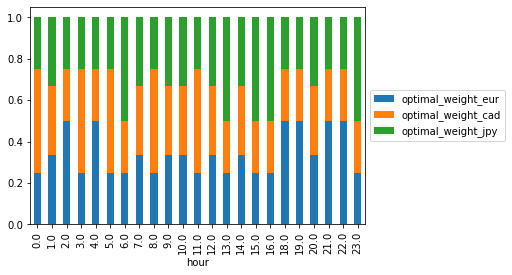

In [67]:
ax = qfunction.set_index('hour').plot(kind='bar',stacked=True)
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.figure.savefig('RL-specifichour_'+str(weightOptions)+'.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [28]:
test_return = pd.DataFrame()
for h in range(len(hour_start_test)-1):
    curr = State(hour_start_test.index[h].hour)
    optimal_weight = learner.greedy_action(curr).weight
    
    test_df = ret_df[(ret_df.index <= hour_start_test.index[h+1]) & (ret_df.index > hour_start_test.index[h])]

    test_performance = list(optimal_weight)*test_df
    test_port = test_performance.sum(axis=1)
    test_return = test_return.append(pd.DataFrame(test_port))

test_return.std()*np.sqrt(23*60*252)

0    0.077515
dtype: float64